In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
from scipy.signal import correlate

In [2]:
# Daily new cases for Italy
nIT = np.loadtxt('new_cases-italy.txt')

# Positivity rate for Italy (already a 7-days moving average)
PosRateIT = np.loadtxt('posRate-italy.csv')

# First day is March 9 2020

# Populations
pIT = 60e6

# Lets apply a seven-day moving average and normalize per 1e6 inhabitants
nIT_ma = np.zeros(nIT.size-7)

for i in range(nIT_ma.size):
    nIT_ma[i] = np.mean(nIT[i:i+7])/pIT*1e6

In [3]:
def doubling_times(x):
    x_ref = x[0]
    times = [0]
    j = 0
    while j != (len(x)-1):
        for j in range(j,len(x)):

            if x[j]>=2*x_ref:
                times.append(j)
                x_ref = x[j]
                break

    return times        

In [4]:
K = 200
    
NInf = np.zeros((K,200))
NTes = np.zeros((K,200))
NPos = np.zeros((K,200))
for k in range(10):
    NInf[k,:] = np.loadtxt('data/NInf_R0=2.7_k={}.dat'.format(k))
    NTes[k,:] = np.loadtxt('data/NTes_R0=2.7_k={}.dat'.format(k))
    NPos[k,:] = np.loadtxt('data/NPos_R0=2.7_k={}.dat'.format(k))

NPos[np.where(NPos==0)] = np.nan    # Fix missing data
NTes[np.where(NTes==0)] = np.nan    # Fix missing data
NewPos = np.gradient(NPos,axis=1)   # New positive
PosRate = NewPos/NTes               # Postive ratio

k=7
PosRateMA = correlate(np.nanmean(PosRate,axis=0),np.ones(k)/k,mode='same')

<ipython-input-4-08b782aedc0a>:17: RuntimeWarning: Mean of empty slice
  PosRateMA = correlate(np.nanmean(PosRate,axis=0),np.ones(k)/k,mode='same')


<ipython-input-5-f0d93d0187c1>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('Fig3.pdf')
/home/nbudanur/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


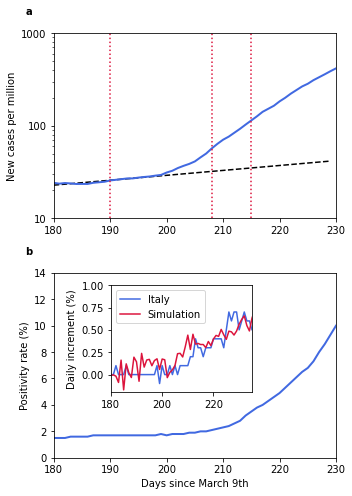

In [5]:
fig, ax = plt.subplots(2,1,figsize=(5,7),tight_layout=True)

axi  = inset_axes(ax[1],width='100%',height='100%',bbox_to_anchor=(.22, .38, .5, .58),bbox_transform=ax[1].transAxes)


# Doubling times
x1, x2 = [180, 230]
dx = 10

dt = doubling_times(nIT_ma[x1+dx:])
y1, y2 = [10, 1000]


ax[0].plot(nIT_ma,color='royalblue',lw=2)
for i in range(len(dt))[:-2]:
    ax[0].plot([dt[i]+x1+dx, dt[i]+x1+dx], [y1, y2], ':',color='crimson')


c = np.polyfit(np.arange(180,200),np.log(nIT_ma[180:200]),1)
ax[0].plot(np.arange(x1,x2),np.exp(np.polyval(c,np.arange(x1,x2))),'k--',zorder=-1)

ax[0].set_xlim([x1, x2])
ax[0].set_ylim([y1, y2])
ax[0].set_yscale('log')
# ax[0].set_xlabel('Days since March 9th')
ax[0].set_ylabel('New cases per million')
ax[0].text(-.1,1.1,r'a',transform=ax[0].transAxes,fontweight='bold')
# ax[0].set_yticks([10,20,40,100,200,400])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))


ax[1].plot(PosRateIT*100,color='royalblue',lw=2)
ax[1].set_xlim([x1,x2])
ax[1].set_ylim([0,14])
ax[1].set_ylabel('Positivity rate (%)')
ax[1].set_xlabel('Days since March 9th')
ax[1].text(-.1,1.1,r'b',transform=ax[1].transAxes,fontweight='bold')

axi.plot(np.diff(PosRateIT*100),color='royalblue',label='Italy')
axi.plot(np.arange(PosRateMA.size-1)+115,np.diff(PosRateMA*100),color='crimson',label='Simulation')
axi.set_xlim([180,235])
axi.set_ylim([-0.2,1])
axi.set_ylabel('Daily increment (%)')
axi.legend(loc='upper left')

fig.savefig('Fig3.pdf')